In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from kmodes.kmodes import KModes
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
donnees = pd.read_csv("explorationML4.csv")

In [4]:
# Search for the earliest date 
ancien = donnees["order_purchase_timestamp"].min()
ancien

'2016-09-04 21:15:19'

In [5]:
# search for the most recent date
recent = donnees["order_purchase_timestamp"].max()
recent

'2018-09-03 09:06:57'

In [6]:
import datetime as dt
aammjj = str.split(str.split(recent)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]) + 1)

In [7]:
# Change the type of "order_purchase_timestamp" at datetime 
donnees["order_purchase_timestamp"] = pd.to_datetime(donnees["order_purchase_timestamp"])

In [8]:
# Set up the RFM table
#
# Recency: number of days elapsed since last purchase
# 
# Frequency: the number of times the customer has made a purchase
#
# Monetary: the total amount spent by a client
rfmTable = donnees.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "order_id": lambda x: x.nunique(),
                 "price": lambda x: sum(x)})

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency',
                         'order_id': 'frequency',
                         'price': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [9]:
quartiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])    # Calculate quartile values for the dataset
print(quartiles)

      recency  frequency  monetary_value
0.25  119.0    1.0        47.90         
0.50  223.0    1.0        89.90         
0.75  352.0    1.0        156.45        


In [10]:
quartiles = quartiles.to_dict()    # Trsnformation dataframe to dictionary
quartiles

{'recency': {0.25: 119.0, 0.5: 223.0, 0.75: 352.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 47.9, 0.5: 89.9, 0.75: 156.45}}

In [11]:
segmented_rfm = rfmTable.copy()

In [12]:
def RScore(x,p,d):
    """Returns the recent score for a value relative to quartile value"""
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    """Returns the frequency and monetary score  for a value relative to quartile value"""
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [13]:
# Table RFM with score 
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore,
                                                             args=('recency',quartiles)
                                                            )
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore,
                                                               args=('frequency',quartiles)
                                                              )
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore,
                                                                    args=('monetary_value',quartiles)
                                                                   )

segmented_rfm['RFMScore'] = (segmented_rfm["r_quartile"].astype(str) + "-").\
                                str.cat(segmented_rfm["f_quartile"].astype(str) + "-").\
                                str.cat(segmented_rfm["m_quartile"].astype(str))

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,4,2,1-4-2
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,4,4,1-4-4
0000f46a3911fa3c0805444483337064,542,1,69.00,4,4,3,4-4-3
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,4,4,3-4-4
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,4,1,3-4-1


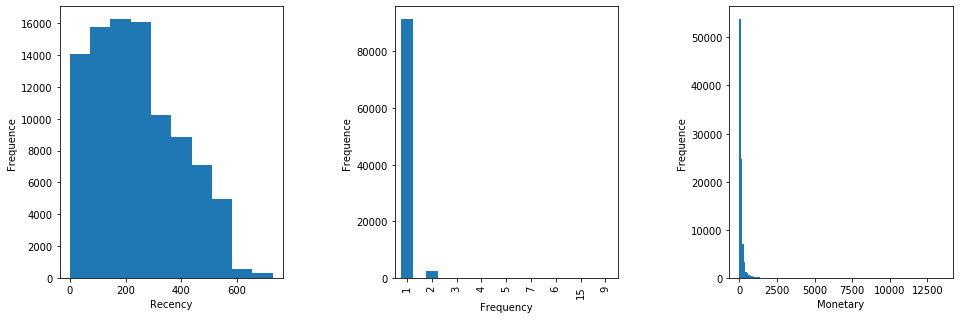

In [14]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

r = segmented_rfm['recency']
m = segmented_rfm['monetary_value']

plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace= 0.5)

# Recency
plt.subplot(131)
plt.xlabel('Recency')
plt.ylabel('Frequence')
counts, bins = np.histogram(r)
plt.hist(bins[:-1], bins, weights=counts)

# Frequency
plt.subplot(132)
plt.xlabel('Frequency')
plt.ylabel('Frequence')
segmented_rfm['frequency'].value_counts().plot(kind="bar", width=0.5)

# Monetary
plt.subplot(133)
plt.xlabel('Monetary')
plt.ylabel('Frequence')
bins = compute_histogram_bins(m, 100)
plt.hist(m, bins=bins)

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x173aa07be08>,
 'caps': [<matplotlib.lines.Line2D at 0x173aa04cdc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x173aa07b308>],
 'medians': [<matplotlib.lines.Line2D at 0x173aa085d48>],
 'fliers': [<matplotlib.lines.Line2D at 0x173aa085b08>],
 'means': []}

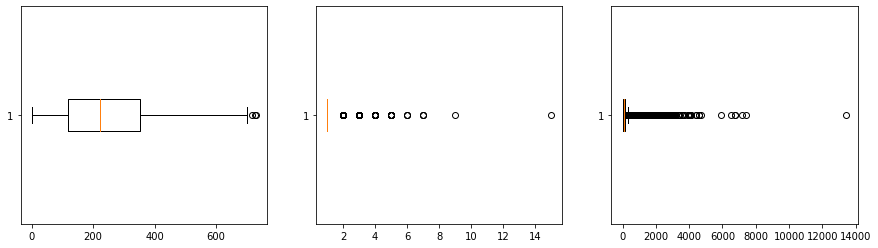

In [15]:
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.boxplot(segmented_rfm["recency"], vert=False)

ax = fig.add_subplot(132)
ax.boxplot(segmented_rfm["frequency"], vert=False)

ax = fig.add_subplot(133)
ax.boxplot(segmented_rfm["monetary_value"], vert=False)

In [16]:
segmented_rfm['RFMScore'].unique()

array(['1-4-2', '1-4-4', '4-4-3', '3-4-4', '3-4-1', '2-4-2', '2-4-4',
       '2-4-1', '4-4-2', '4-4-4', '3-4-3', '2-4-3', '4-4-1', '1-4-3',
       '1-4-1', '3-4-2', '3-1-1', '1-1-3', '2-1-2', '4-1-1', '2-1-1',
       '1-1-1', '2-1-4', '4-1-3', '3-1-2', '1-1-2', '3-1-3', '1-1-4',
       '2-1-3', '4-1-4', '4-1-2', '3-1-4'], dtype=object)

In [17]:
mean_var = segmented_rfm.groupby("RFMScore")[["recency", "frequency",
                                              "monetary_value"]].agg([np.mean, np.var])
mean_var["size"] = segmented_rfm.groupby('RFMScore')[['recency']].agg([np.size]) 
mean_var

recency              frequency           monetary_value  \
                mean          var      mean       var           mean   
RFMScore                                                               
1-1-1     64.043564   1110.275876  2.227723  0.688119  390.359465      
1-1-2     61.455556   1070.361142  2.038889  0.037585  120.796722      
1-1-3     66.563830   1097.237817  2.042553  0.041181  70.661277       
1-1-4     60.480000   1393.010000  2.000000  0.000000  36.312400       
1-4-1     63.515836   1101.882252  1.000000  0.000000  368.460493      
1-4-2     63.639231   1112.854918  1.000000  0.000000  119.526550      
1-4-3     60.711919   1126.555595  1.000000  0.000000  66.520719       
1-4-4     61.690692   1119.372805  1.000000  0.000000  29.311692       
2-1-1     174.532520  892.827861   2.168699  0.376778  365.225366      
2-1-2     170.921687  920.436254   2.066265  0.062249  122.347169      
2-1-3     172.414634  1005.801265  2.012195  0.012195  71.559268       
2-1-4     168.240000  848.190000   2.000000  0.000000  33.818400       
2-4-1     169.993258  895.427563   1.000000  0.000000  348.085051      
2-4-2     169.895908  924.475611   1.000000  0.000000  120.623489      
2-4-3     171.127868  902.610486   1.000000  0.000000  66.623783       
2-4-4     172.772252  859.648847   1.000000  0.000000  29.464815       
3-1-1     283.520642  1348.406469  2.107798  0.133180  405.153784      
3-1-2     281.892405  1305.230388  2.018987  0.018745  121.841139      
3-1-3     286.536585  1064.498645  2.012195  0.012195  69.652317       
3-1-4     291.411765  1323.382353  2.000000  0.000000  40.706471       
3-4-1     283.405519  1253.354991  1.000000  0.000000  347.300715      
3-4-2     282.259093  1231.628940  1.000000  0.000000  119.656115      
3-4-3     281.899701  1248.220962  1.000000  0.000000  66.829309       
3-4-4     281.303377  1248.684200  1.000000  0.000000  29.089172       
4-1-1     439.862573  4393.379885  2.081871  0.081254  416.046520      
4-1-2     443.700680  4344.457739  2.047619  0.045662  124.479796      
4-1-3     459.272727  4305.647552  2.106061  0.311655  70.195303       
4-1-4     484.187500  6883.899194  2.156250  0.200605  33.655000       
4-4-1     460.122991  5465.397985  1.000000  0.000000  364.044593      
4-4-2     458.014057  5067.088317  1.000000  0.000000  118.421639      
4-4-3     452.613838  4953.946659  1.000000  0.000000  66.945356       
4-4-4     460.526254  5098.075645  1.000000  0.000000  28.942839       

                         size  
                    var        
RFMScore                       
1-1-1     121609.041936  505   
1-1-2     315.336591     180   
1-1-3     133.666044     94    
1-1-4     67.821627      25    
1-4-1     147849.568726  5399  
1-4-2     342.967106     5771  
1-4-3     153.907348     5856  
1-4-4     105.664329     5952  
2-1-1     71585.021583   492   
2-1-2     338.164315     166   
2-1-3     145.508901     82    
2-1-4     77.129797      25    
2-4-1     94695.994773   5340  
2-4-2     363.712377     5572  
2-4-3     166.794237     5709  
2-4-4     107.338941     5932  
3-1-1     118779.265718  436   
3-1-2     349.068294     158   
3-1-3     169.145766     82    
3-1-4     53.363062      17    
3-4-1     120713.371720  5472  
3-4-2     364.179411     5361  
3-4-3     173.938000     6351  
3-4-4     104.392903     5686  
4-1-1     281979.244514  342   
4-1-2     342.965594     147   
4-1-3     146.509041     66    
4-1-4     69.538058      32    
4-4-1     128796.448766  5537  
4-4-2     324.381888     5051  
4-4-3     171.248104     6316  
4-4-4     109.713155     5942

In [18]:
# Contingency table
# Recency X frequency, Recency X Monetary_value, Frequency X Monetary_value
RF = pd.DataFrame(columns=['1', '2', '3', '4'])
RM = pd.DataFrame(columns=['1', '2', '3', '4'])
FM = pd.DataFrame(columns=['1', '2', '3', '4'])
size = segmented_rfm.shape[0]
for i in range(1, 5):
    row_crf = []
    row_crm = []
    row_cfm = []
    for j in range(1, 5):
        crf = 0
        crm = 0
        cfm = 0
        for k, row in segmented_rfm.iterrows():
            if row["r_quartile"] == i and row["f_quartile"] == j:
                crf += 1
            if row["r_quartile"] == i and row["m_quartile"] == j:
                crm += 1
            if row["f_quartile"] == i and row["m_quartile"] == j:
                cfm += 1
        row_crf.append(crf)
        row_crm.append(crm)
        row_cfm.append(cfm)
    RF.loc[i] = row_crf
    RM.loc[i] = row_crm
    FM.loc[i] = row_cfm

In [19]:
RF.style.set_caption("Recency X Frequency")
RF

,1,2,3,4
1,804,0,0,22978
2,765,0,0,22553
3,693,0,0,22870
4,587,0,0,22846


In [20]:
RM.style.set_caption("Recency X Monetary")
RM

,1,2,3,4
1,5904,5951,5950,5977
2,5832,5738,5791,5957
3,5908,5519,6433,5703
4,5879,5198,6382,5974


In [21]:
FM.style.set_caption("frequency X Monetary")
FM

,1,2,3,4
1,1775,651,324,99
2,0,0,0,0
3,0,0,0,0
4,21748,21755,24232,23512


In [22]:
customer_segment = pd.DataFrame()
segment = ["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost",
           "Lost Customers", "Lost Cheap Customers", "Autres"
          ]
rfm = ["1-1-1", "X-1-X", "X-X-1", "3-1-1", "4-1-1", "4-4-4", "Autres"]
description = ["Les clients qui ont acheté le plus récemment, le plus souvent \
               et qui dépensent le plus.",
               "Les clients ayant acheté le plus récemment",
               "Les clients qui dépensent le plus",
               "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
               et ont dépensé le plus.",
               "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont \
               dépensé le plus.",
               "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
               ""
              ]
marketing = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
             "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
             "Commercialisez vos produits les plus chers.",
             "Offrez d'autres produits pertinents et des rabais spéciaux.",
             "Incitations à des prix agressifs",
             "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             "Ajuster les intervales pour le réduire si important"
            ]
customer_segment["rfm"] = rfm
customer_segment["segments clients"] = segment 

In [23]:
sums = []
X1X = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4"]
XX1 = ["1-2-1", "1-3-1", "1-4-1", "2-2-1", "2-3-1", "2-4-1"]
for r in rfm:
    count = 0
    if r == "X-1-X":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in X1X:
                count += 1
        sums.append(count)
    if r == "X-X-1":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in XX1 and r != "2-1-1":
                count += 1
        sums.append(count)
    if r != "X-1-X" and r != "X-X-1" and r != "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] == r:
                count += 1
        sums.append(count)
    if r == "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] not in rfm and row["RFMScore"] not in X1X and \
            row["RFMScore"] not in XX1:
                count += 1
        sums.append(count)
        
customer_segment["nombre de clients"] = sums

In [24]:
customer_segment["activité"] = description
customer_segment["Conseil d'action"] = marketing

# Customer/segment
customer_segment

,rfm,segments clients,nombre de clients,activité,Conseil d'action
0,1-1-1,Best Customers,505,"Les clients qui ont acheté le plus récemment, le plus souvent et qui dépensent le plus.","Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité"
1,X-1-X,Loyal Customers,1064,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.
2,X-X-1,Big Spenders,10739,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
3,3-1-1,Almost Lost,436,"N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment et ont dépensé le plus.",Offrez d'autres produits pertinents et des rabais spéciaux.
4,4-1-1,Lost Customers,342,"N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont dépensé le plus.",Incitations à des prix agressifs
5,4-4-4,Lost Cheap Customers,5942,"Dernier achat il y a longtemps, acheté peu et dépensé peu.",Ne passez pas trop de temps à essayer de vous ré-acquérir.
6,Autres,Autres,75068,,Ajuster les intervales pour le réduire si important


In [25]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers", "Autres"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
                ""
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
              "Ajuster les intervales pour le réduire si important"
             ]
customer_segment_["segment"] = segment_

In [26]:
recents_ = []
def countCustomerSegment(segmented_rfmp):
    """Main function is to return the customer identities for each segment"""
    seg_cus_id = {"Best Customers": [], "Loyal Customers": [], "Promissing": [],
                  "Big Spenders": [],"Almost Lost": [], "Lost Customers": [],
                  "Lost Cheap Customers": [], "Autres": []}
    sums_ = []
    best = ["1-1-1"]
    X1X_ = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4", "1-4-2", "2-4-2"]
    promiss = ["1-4-3", "1-4-4", "2-4-3", "2-4-4"]
    XX1_ = ["1-2-1", "1-3-1", "1-4-1", "2-3-1", "2-4-1"]
    almost_lost = ["3-1-1", "3-4-1", "3-4-2"]
    lost = ["3-4-3", "3-4-4", "4-1-1", "4-4-1", "4-4-2"]
    lost_cheap = ["4-4-4", "4-4-3"]
    for s in segment_:
        count = 0
        rec = 0
        if s == "Best Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in best:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Loyal Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in X1X_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Promissing":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in promiss:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Big Spenders":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in XX1_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Almost Lost":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in almost_lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Cheap Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Autres":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] not in best and row["RFMScore"] not in X1X_ \
                and row["RFMScore"] not in XX1_ and row["RFMScore"] not in promiss and \
                row["RFMScore"] not in lost and row["RFMScore"] not in almost_lost and \
                row["RFMScore"] not in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
                    
        sums_.append(count)
        recents_.append(int(rec/count))
        
    return (seg_cus_id,sums_)

In [27]:
cus_id, customer_segment_["nombre de clients"] = countCustomerSegment(segmented_rfm)
customer_segment_["description"] = description_
customer_segment_["marketing"] = marketing_

#customer/segment
customer_segment_

,segment,nombre de clients,description,marketing
0,Best Customers,505,"Les clients qui ont acheté le plus récemment, le plus souvent et qui dépensent le plus.","Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité"
1,Loyal Customers,12407,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.
2,Promissing,23449,"Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",offrir des essais gratuits
3,Big Spenders,10739,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
4,Almost Lost,11269,"N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment et ont dépensé le plus.",Offrez d'autres produits pertinents et des rabais spéciaux.
5,Lost Customers,22967,"N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont dépensé le plus.",Incitations à des prix agressifs
6,Lost Cheap Customers,12258,"Dernier achat il y a longtemps, acheté peu et dépensé peu.",Ne passez pas trop de temps à essayer de vous ré-acquérir.
7,Autres,502,,Ajuster les intervales pour le réduire si important


Text(0, 0.5, 'Nombre de clients par segments')

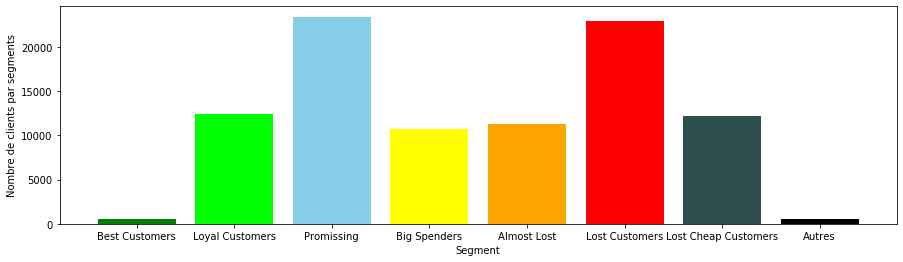

In [28]:
plt.figure(figsize=(15, 4))
plt.bar(customer_segment_["segment"], customer_segment_["nombre de clients"], align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange", "red", "#2F4F4F", "black"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

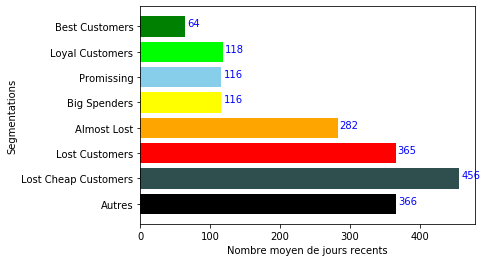

In [29]:
fig, ax = plt.subplots() 
ax.barh(customer_segment_["segment"].iloc[::-1] , recents_[::-1],
        color=["black", "#2F4F4F", "red", "orange", "yellow","#87ceeb", "lime", "green"]
       )
plt.xlabel('Nombre moyen de jours recents')
plt.ylabel('Segmentations')
for i, v in enumerate(recents_[::-1]):
    ax.text(v + 3, i + .0, str(v), color='blue')

In [30]:
XRFM = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
segments_labels = []
for i, row in XRFM.iterrows():
    if i in cus_id["Best Customers"]:
        segments_labels.append("Best Customers")
        continue
    if i in cus_id["Loyal Customers"]:
        segments_labels.append("Loyal Customers")
        continue
    if i in cus_id["Promissing"]:
        segments_labels.append("Promissing")
        continue
    if i in cus_id["Big Spenders"]:
        segments_labels.append("Big Spenders")
        continue
    if i in cus_id["Almost Lost"]:
        segments_labels.append("Almost Lost")
        continue
    if i in cus_id["Lost Customers"]:
        segments_labels.append("Lost Customers")
        continue
    if i in cus_id["Lost Cheap Customers"]:
        segments_labels.append("Lost Cheap Customers")
        continue
    if i in cus_id["Autres"]:
        segments_labels.append("Autres")
        continue

KeyboardInterrupt: 

In [ ]:
relative_imp_sort = pd.DataFrame()
XRFM["segment_appartenance"] = segments_labels

population = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
population_avg = population.mean()

cluster_avg = XRFM.groupby(['segment_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1

relative_imp_sort["Best Customers"] = relative_imp.loc["Best Customers"]
relative_imp_sort["Loyal Customers"] = relative_imp.loc["Loyal Customers"]
relative_imp_sort["Promissing"] = relative_imp.loc["Promissing"]
relative_imp_sort["Big Spenders"] = relative_imp.loc["Big Spenders"]
relative_imp_sort["Almost Lost"] = relative_imp.loc["Almost Lost"]
relative_imp_sort["Lost Customers"] = relative_imp.loc["Lost Customers"]
relative_imp_sort["Lost Cheap Customers"] = relative_imp.loc["Lost Cheap Customers"]
relative_imp_sort["Autres"] = relative_imp.loc["Autres"]

plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp_sort.T, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

In [ ]:
# Maintenance

In [ ]:
# Retrieve the last three months
past = {}
for i in range(0, 4):
    past[i] = dt.datetime(int(aammjj[0]), int(aammjj[1])-i, int(aammjj[2]))
past

In [ ]:
customerPast = donnees[donnees["order_purchase_timestamp"] < past[3]]
customer_retain = customerPast["customer_unique_id"].unique()

In [ ]:
dist = {}
cus_id_list = {}
dict_rfmTable = {}
for i in range(0, 4):
    customerPast = donnees[donnees["order_purchase_timestamp"] < past[i]]
    customerPast = customerPast[customerPast["customer_unique_id"].isin(list(customer_retain))]
    rfmTablePast = customerPast.groupby('customer_unique_id').\
                    agg({"order_purchase_timestamp": lambda x: (past[i] - x.max()).days,
                         "customer_unique_id": lambda x: len(x), "price": lambda x: sum(x)
                        })

    rfmTablePast['order_purchase_timestamp'] = rfmTablePast['order_purchase_timestamp'].astype(int)
    rfmTablePast.rename(columns={'order_purchase_timestamp': 'recency',
                                 'customer_unique_id': 'frequency',
                                 'price': 'monetary_value'
                                },inplace=True
                       )
    
    quartilesPast = rfmTablePast.quantile(q=[0.25, 0.5, 0.75])
    quartilesPast = quartilesPast.to_dict()  #Transformation dataframe en dictionnaire

    rfmTablePast['r_quartile'] = rfmTablePast['recency'].apply(RScore,
                                                               args=('recency',quartilesPast))
    rfmTablePast['f_quartile'] = rfmTablePast['frequency'].apply(FMScore,
                                                                 args=('frequency',quartilesPast))
    rfmTablePast['m_quartile'] = rfmTablePast['monetary_value']. \
                                    apply(FMScore, args=('monetary_value',quartilesPast))

    rfmTablePast['RFMScore'] = (rfmTablePast["r_quartile"].astype(str) + "-"). \
                                str.cat(rfmTablePast["f_quartile"].astype(str) + "-"). \
                                str.cat(rfmTablePast["m_quartile"].astype(str))
    
    cus_id_list[i], dist[i] = countCustomerSegment(rfmTablePast)
    dict_rfmTable[i] = rfmTablePast.copy()
dist

In [ ]:
# Construct matching indices between source and target
s = []
t = []
for i in range(0, 24):
    for j in range(0, 8):
        s.append(i)
    if i in range(0, 8):
        for k in range(8, 16):
            t.append(k)
    if i in range(8, 16):
        for k in range(16, 24):
            t.append(k)
    if i in range(16, 24):
        for k in range(24, 32):
            t.append(k)

In [ ]:
# Construct the values between the sources and the targets
v = []
m_v = {}
for i in range(3, 0, -1):
    m = []
    for j in range(0, 8):
        line = []
        for k in range(0, 8):
            nb_int = len(set(cus_id_list[i][segment_[j]]) & set(cus_id_list[i-1][segment_[k]]))
            v.append(nb_int)
            line.append(nb_int)
        m.append(line)
    m_v[i] = m

In [ ]:
# Set up labels and colors
ls = []
c = []
labels_set = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
              "Almost Lost", "Lost Customers", "Lost Cheap Customers", "Autres"]
colors_set = ["green", "lime", "#87ceeb", "yellow", "orange", "red", "#2F4F4F", "black"]

for i in range(1, 5):
    for j in range(0, 8):
        ls.append(labels_set[j] + str(i))
        c.append(colors_set[j])

In [ ]:
# Display Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ls,  
      color = c
    ),
    link = dict(
      source = s,
      target = t,
      value = v
  ))])

fig.update_layout(title_text="Diagramme de flux de clients entre segments", font_size=10)
fig.show()

In [ ]:
values1 = pd.DataFrame(m_v[3])  # (2018, 6, 3, 0, 0) to (2018, 7, 3, 0, 0)
values1 = values1.rename(index={0: "Best Customers (2018, 6, 3)", 1: "Loyal Customers (2018, 6, 3)",
                                2: "Promissing (2018, 6, 3)", 3: "Big Spenders (2018, 6, 3)",
                                4: "Almost Lost (2018, 6, 3)", 5: "Lost Customers (2018, 6, 3)",
                                6: "Lost Cheap (2018, 6, 3)", 7: "Autres (2018, 6, 3)"
                               },
                         columns={0: "Best Customers (2018, 7, 3)", 1: "Loyal Customers (2018, 7, 3)",
                                  2: "Promissing (2018, 7, 3)", 3: "Big Spenders (2018, 7, 3)",
                                  4: "Almost Lost (2018, 7, 3)", 5: "Lost Customers (2018, 7, 3)",
                                  6: "Lost Cheap (2018, 7, 3)", 7: "Autres (2018, 7, 3)"
                               }
                        )
values1

In [ ]:
values2 = pd.DataFrame(m_v[2])  # (2018, 7, 3, 0, 0) to (2018, 8, 3, 0, 0)
values2 = values2.rename(index={0: "Best Customers (2018, 7, 3)", 1: "Loyal Customers (2018, 7, 3)",
                                  2: "Promissing (2018, 7, 3)", 3: "Big Spenders (2018, 7, 3)",
                                  4: "Almost Lost (2018, 7, 3)", 5: "Lost Customers (2018, 7, 3)",
                                  6: "Lost Cheap (2018, 7, 3)", 7: "Autres (2018, 7, 3)"
                               },
                         columns={0: "Best Customers (2018, 8, 3)", 1: "Loyal Customers (2018, 8, 3)",
                                  2: "Promissing (2018, 8, 3)", 3: "Big Spenders (2018, 8, 3)",
                                  4: "Almost Lost (2018, 8, 3)", 5: "Lost Customers (2018, 8, 3)",
                                  6: "Lost Cheap (2018, 8, 3)", 7: "Autres (2018, 8, 3)"
                               }
                        )
values2

In [ ]:
values3 = pd.DataFrame(m_v[1])  # (2018, 8, 3, 0, 0) to (2018, 9, 3, 0, 0)
values3 = values3.rename(index={0: "Best Customers (2018, 8, 3)", 1: "Loyal Customers (2018, 8, 3)",
                                2: "Promissing (2018, 8, 3)", 3: "Big Spenders (2018, 8, 3)",
                                4: "Almost Lost (2018, 8, 3)", 5: "Lost Customers (2018, 8, 3)",
                                6: "Lost Cheap (2018, 8, 3)", 7: "Autres (2018, 8, 3)"
                               },
                         columns={0: "Best Customers (2018, 9, 3)", 1: "Loyal Customers (2018, 9, 3)",
                                  2: "Promissing (2018, 9, 3)", 3: "Big Spenders (2018, 9, 3)",
                                  4: "Almost Lost (2018, 9, 3)", 5: "Lost Customers (2018, 9, 3)",
                                  6: "Lost Cheap (2018, 9, 3)", 7: "Autres (2018, 9, 3)"
                               }
                        )
values3

In [ ]:
for i in range(1, 0, -1):  # Last month: (2018, 8, 3, 0, 0) to (2018, 9, 3, 0, 0)
    id_list = []
    for j in range(0, 1):  # Best Customers, Loyal Customers
        for k in range(4, 7):  # Almost Lost, Lost Customers, Lost Cheap Customers
            temp = list(set(cus_id_list[i][segment_[k]]) & set(cus_id_list[i-1][segment_[j]]))
            for m in temp:
                id_list.append(m)  
    df1 = dict_rfmTable[i][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df1 = df1.rename(columns={"recency": "recency (2018, 8, 3)", "frequency": "frequency (2018, 8, 3)",
                              "monetary_value": "monetary_value (2018, 8, 3)",
                              "RFMScore": "RFMScore (2018, 8, 3)"
                             }
                    )
    df2 = dict_rfmTable[i-1][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df2 = df2.rename(columns={"recency": "recency (2018, 9, 3)", "frequency": "frequency (2018, 9, 3)",
                              "monetary_value": "monetary_value (2018, 9, 3)",
                              "RFMScore": "RFMScore (2018, 9, 3)"
                             }
                    )
    
    df = pd.concat([df1, df2], axis=1, sort=False)

In [ ]:
df

In [ ]:
# KModes algorithm

In [ ]:
# One Hot encoding
grouped = donnees[['customer_unique_id', 'product_category_name']].\
    groupby('customer_unique_id')

In [ ]:
cus_prod = {}
for name, group in grouped:
    cus_prod[name] = list(set(group["product_category_name"].values))

In [ ]:
cus_prod

In [ ]:
colname_indice = {}
i = 0
for cat in donnees["product_category_name"].unique():
    colname_indice[cat] = i
    i += 1

In [ ]:
OH_cols = pd.DataFrame(columns=list(donnees["product_category_name"].unique()))
OH_cols

In [ ]:
for k, v in cus_prod.items():
    row = [0]*OH_cols.shape[1]
    for cat in v:
        row[colname_indice[cat]] = 1
    OH_cols.loc[k] = row

In [ ]:
OH_cols.head()

In [ ]:
# Search for the optimal hyperparameter k
sum_distances = []
K = range(1,15)
for k in K:
    km = KModes(n_clusters=k, init='random')
    km.fit_predict(OH_cols)
    sum_distances.append(km.cost_)
kk = sum_distances.index(min(sum_distances)) + 1

print("le nombre de clusters optimal est : {}".format(kk))

plt.plot(K, sum_distances, 'ro-')
plt.xlabel('k')
plt.ylabel('sum_distances')
plt.title('Recherche le nombre de clusters k optimal')

plt.show()

In [ ]:
# Group related categories
km = KModes(n_clusters=kk, init='random', n_init=kk+1)
km.fit_predict(OH_cols)
kmodes = km.cluster_centroids_
shape = kmodes.shape
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("cluster sans catégorie")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in OH_cols.columns[np.nonzero(cent)]:
            print(j)

In [ ]:
donnees["product_category_name"].value_counts()[:20]

In [ ]:
x = []
y = []
for i in range(0, kk):
    x.append("C " + str(i))
    y.append(np.sum(km.labels_== i))
    
plt.xlabel('Clusters')
plt.ylabel('Nombre de clients')
plt.bar(x, y)

In [ ]:
# K-means algorithm

```
Fusion feature : product_category_name, R, F, M
```

In [ ]:
X = pd.concat([rfmTable, OH_cols], axis=1)

In [ ]:
X.shape

```
Add number of products bought
```

In [ ]:
nb_prod_by_cus = donnees[["customer_unique_id", "order_id"]].\
    groupby('customer_unique_id').count()

nb_prod_by_cus = nb_prod_by_cus.rename(columns={"order_id": "nb_prod_by_cus"})

In [ ]:
X = pd.concat([X, nb_prod_by_cus], axis=1)

In [ ]:
X.head()

```
Add mean score
```

In [ ]:
mean_score = donnees[['customer_unique_id', 'review_score']].\
    groupby('customer_unique_id').mean()

mean_score = mean_score.rename(columns={"review_score": "mean_score"})

In [ ]:
mean_score

In [ ]:
X = pd.concat([X, mean_score], axis=1)

In [ ]:
X.head()

```
Add One Hot state
```

In [ ]:
grouped = donnees[['customer_unique_id', 'customer_state']].\
    groupby('customer_unique_id')

In [ ]:
state_cus = {}
for name, group in grouped:
    state_cus[name] = list(set(group["customer_state"].values))

In [ ]:
state_cus

In [ ]:
colstate_indice = {}
i = 0
for state in donnees["customer_state"].unique():
    colstate_indice[state] = i
    i += 1

In [ ]:
OH_cols = pd.DataFrame(columns=list(donnees["customer_state"].unique()))
OH_cols

In [ ]:
for k, v in state_cus.items():
    row = [0]*OH_cols.shape[1]
    for state in v:
        row[colstate_indice[state]] = 1
    OH_cols.loc[k] = row

In [ ]:
OH_cols.head()

In [ ]:
X = pd.concat([X, OH_cols], axis=1)

```
Add density population of state
```

In [ ]:
cus_state_nunique = dict(donnees["customer_state"].value_counts())

In [ ]:
col_state_count = []
for k, v in state_cus.items():
    col_state_count.append(cus_state_nunique[v[0]])

In [ ]:
X["nb_cus_by_state"] = col_state_count

In [ ]:
X.head()

In [ ]:
for f in X.columns:
    X[f] = X[f].astype(float)

In [ ]:
X["monetary_value"] = np.log1p(X["monetary_value"])

In [ ]:
# To scale the features 
X_scale = preprocessing.StandardScaler().fit_transform(X)

In [ ]:
X_scale = pd.DataFrame(X_scale, index=list(X.index), columns=X.columns)

# Dimensionality Reduction

In [ ]:
pca = PCA().fit(X_scale)

In [ ]:
pca

In [ ]:
components_total = len(pca.explained_variance_ratio_)
components_total

In [ ]:
components = np.arange(components_total)

In [ ]:
# Investigate the variance accounted for by each principal component.
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(components, pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red", marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")

plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [ ]:
pca_50 = PCA(n_components=50).fit(X_scale)

In [ ]:
pca_50.explained_variance_ratio_.sum()

# Interpret Principal Components

In [ ]:
def get_cpn_feat_wgt(pca, x_scale, cpn_num):
    '''
    Give feature weight of n-th component of pca object
    '''
    weights = pd.DataFrame(np.round(pca.components_, 4),
                           columns=x_scale.columns)
    weight_n = weights.iloc[cpn_num-1, :].sort_values()
    weight_n = weight_n.to_frame()
    weight_n.reset_index(level=0, inplace=True)
    weight_n.columns = ['colname', 'weight']
    return weight_n

In [ ]:
def get_top_feature(cpn_feat_wgt, n=5):
    tail_n = cpn_feat_wgt.head(n).reset_index(drop=True)
    head_n = cpn_feat_wgt.tail(n).\
        sort_values(by='weight', ascending=False).reset_index(drop=True)
    top_n = pd.concat([head_n, tail_n], axis=1)
    top_n.columns = ['top_pos_col', 'top_pos_col_wgt',
                     'top_neg_col', 'top_neg_col_wgt']
    return top_n

In [ ]:
cpn_wgt_1st = get_cpn_feat_wgt(pca_50, X_scale, 1)
get_top_feature(cpn_wgt_1st, 5).style.\
    bar(subset=['top_pos_col_wgt', 'top_neg_col_wgt'],
        align='mid', color=['#d65f5f', '#5fba7d'])

In [ ]:
X_pca_50 = pca_50.transform(X_scale)

In [ ]:
X_pca_50

In [ ]:
X_red = pd.concat([X_scale[["recency", "frequency", "monetary_value", 'nb_prod_by_cus', 'nb_cus_by_state']],
                   X_scale.loc[:, 'SP':'AC']], axis=1)

In [ ]:
X_red

In [ ]:
# Search for the optimal hyperparameter k
silhouettes = []
sum_mean_square_distances = []
interval = range(5, 16)
for num_clusters in interval:
    print(num_clusters)
    cls = KMeans(n_clusters=num_clusters)
    cls.fit(X_red)
    X1 = X_red.copy()
    X1["cluster_appartenance"] = cls.labels_
    stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]].agg([np.mean])
    print(stats1)
    print("")
    score = metrics.silhouette_score(X_red, cls.labels_)
    silhouettes.append(score)
n_clusters = silhouettes.index(max(silhouettes)) + min(interval)

print("Le nombre de clusters optimal est : {}".format(n_clusters))
print("La valeur de la silhouette est de : {}".format(max(silhouettes)))

plt.plot(interval, silhouettes, marker="o")

In [ ]:
pca = PCA(n_components=2).fit(X_scale)
reduced_data = pca.transform(X_scale)
print("Valeur expliquée par les deux premières composantes : %.3f" \
      % pca.explained_variance_ratio_.cumsum()[1])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# Plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # luster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Composant principal 1")
    ax2.set_ylabel("Composant principal 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [ ]:
n_clusters = 14

In [ ]:
clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(X_red)

In [ ]:
X1 = X_red.copy()
X1["cluster_appartenance"] = cluster_labels
stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st1 = stats1.copy()
st1["size"] = X1.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st1

In [ ]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu."
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             ]
identify_clusters = [11, 6, 3, 13, 0, 8, 2]  # Identify at each execution
nb_cust_ = []
for i in identify_clusters:
    nb_cust_.append(st1.loc[i, "size"].values[0])
customer_segment_["segment"] = segment_
customer_segment_["matching_cluster"] = clusters
customer_segment_["number of customers"] = nb_cust_
customer_segment_["segment description"] = description_
customer_segment_["marketing action"] = marketing_

In [ ]:
# customer_segment_

In [ ]:
vm = pd.DataFrame(stats1.values.T)
stand = preprocessing.StandardScaler().fit_transform(vm)
sns.set()
sns.lineplot(data=stand, hue="Clusters", markers=True)

In [ ]:
population_avg = X.mean()
cluster_avg = X1.groupby(['cluster_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

In [ ]:
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels2 = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels2)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels2)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels2 == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels2.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [ ]:
X2 = X.copy()
X2["cluster_appartenance"] = cluster_labels2
stats2 = X2.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st2 = stats2.copy()
st2["size"] = X2.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st2

In [ ]:
vm = pd.DataFrame(stats2.values.T)
stand = preprocessing.StandardScaler().fit_transform(vm)
sns.set()
sns.lineplot(data=stand, markers=True)

In [ ]:
population_avg = X.mean()
cluster_avg = X2.groupby(['cluster_appartenance']).mean()
relative_imp2 = cluster_avg / population_avg - 1

In [ ]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp2, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

In [ ]:
# DBSCAN Algorithm 

In [ ]:
sns.set(style="ticks", color_codes=True)
eps = [0.5, 2]
neighs = [3, 5]
silhouettes = []
i = 0
score_max = 0
v_eps = 0
v_neigh = 0
for ep in eps:
    for n in neighs:
        db = DBSCAN(eps=ep, min_samples=n).fit(X_scale)
        score = metrics.silhouette_score(X_scale, db.labels_)
        silhouettes.append(score)
        if i == 0:
            v_eps = ep
            v_neigh = n
            score_max = score
            i += 1
        else:
            if score > score_max:
                v_eps = ep
                v_neigh = n
                score_max = score
print(v_eps)
print(v_neigh)
sns.lineplot(x=eps, y=silhouettes, hue=[3, 5, 3, 5], marker="o")

In [ ]:
v_eps = 1

In [ ]:
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

db = DBSCAN(eps=v_eps, min_samples=10).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(reduced_data, labels))

# Black removed and is used for noise instead.
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 4)
colors = cm.nipy_spectral(labels.astype(float) / n_clusters_)
ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')
plt.show()

In [ ]:
# Agglomerative clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)